In [70]:
from IPython.display import Latex, Math
from IPython.display import Image

In [71]:
from collections import Counter
from itertools import chain, islice, repeat
import json
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import  normalize

from scipy.stats import chi2, chi2_contingency, poisson
import seaborn as sns

In [72]:
plt.rc('font', size = 14)

## Aim

This will be a short post in which we will investigate if it is possible to predict cryptocurrency names based on known names.

## Data

The data are collected from the [crypocompare.com website](https://www.cryptocompare.com/).

### Coin list

The list of coins are loaded to the indeed creatively named `coin_df` dataframe.

In [73]:
coin_df = load_df_from_json(r'C:\Users\Balazs\source\repos\CryptoAnalysis\coin_attrs-2018-07-05.json')
coin_df.head()

,Algorithm,CoinName,FullName,FullyPremined,Id,ImageUrl,IsTrading,Name,PreMinedValue,ProofType,SortOrder,Sponsored,Symbol,TotalCoinSupply,TotalCoinsFreeFloat,Url
42,Scrypt,42 Coin,42 Coin (42),0,4321,/media/12318415/42.png,1,42,N/A,PoW/PoS,34,0,42,42,N/A,/coins/42/overview
300,N/A,300 token,300 token (300),0,749869,/media/27010595/300.png,1,300,N/A,N/A,2212,0,300,300,N/A,/coins/300/overview
365,X11,365Coin,365Coin (365),0,33639,/media/352070/365.png,1,365,N/A,PoW/PoS,916,0,365,2300000000,N/A,/coins/365/overview
404,Scrypt,404Coin,404Coin (404),0,21227,/media/351001/404.png,1,404,N/A,PoW/PoS,602,0,404,532000000,N/A,/coins/404/overview
611,SHA256,SixEleven,SixEleven (611),0,20909,/media/350985/611.png,1,611,N/A,PoW,586,0,611,611000,N/A,/coins/611/overview


### Preparation

All names are cast as uppercase and any trailing whitespaces are removed. It is then checked whether there are missing names.

In [74]:
coin_df['clean_name'] = coin_df['CoinName'].apply(lambda x: x.strip().upper())

if coin_df['clean_name'].isnull().values.any():
    print("Warning: Missing name.")
else:
    print("No missing names")

No missing names


## Analysis

### Number of names and characters

Firtsly, the number of names and characters are trivially determined, so that we know what sample sizes we are going to deal with. As we can see the sample size is rather small. The corpus size is in the order of hundred thousands or million words in a usual natural language processing setup.

In [75]:
n_name = coin_df['clean_name'].size
n_char = sum(map(lambda x: len(x), coin_df['clean_name']))
print("Number of names: {0}".format(n_name))
print("Number of characters: {0}".format(n_char))

Number of names: 2717
Number of characters: 25138


### Character frequency

The character frequency yields a rough estimate of the name composition.

In [76]:
raw_char_frequency = Counter(chain(*coin_df['clean_name'].values))
n_letter = len(raw_char_frequency)
raw_chars, raw_freqs = zip(*raw_char_frequency.most_common())

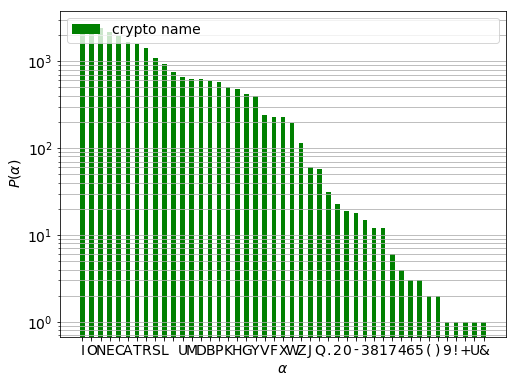

In [77]:
# TO HIDE
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

ax.set_xticks(range(n_letter), raw_chars)
ax.bar(range(n_letter), raw_freqs, width = 0.5, label = 'crypto name', color = 'green')

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$P(\alpha)$')
ax.set_xticks(np.arange(n_letter))
ax.set_xticklabels(raw_chars)
ax.yaxis.grid(which = 'both')
plt.yscale('log')
plt.legend(loc='best', ncol=2, mode="expand", fancybox=True)

plt.show()

There is three orders of magnitude difference between the most and least frequent characters. (The gap between _L_ and _U_ is the _space_ character.) Those names which contain any of the characters of frequency below a certain limit will be removed. This limit is twice the weighted square root of the top five frequencies.

In [78]:
n_top = 5
n_top_freq = np.array(raw_freqs[:n_top], dtype = np.float)
cutoff_freq = 2 * np.dot(np.sqrt(n_top_freq), n_top_freq) / np.sum(n_top_freq) 

discard_chars, _  = zip(*filter(lambda x: x[1] < cutoff_freq, raw_char_frequency.items()))
names = list(filter(lambda x: not any(map(lambda y: y in x, discard_chars)), coin_df['clean_name']))     

The selected names are then saved in the `name_df` dataframe. The number of names and characters are then quickly checked.

In [79]:
name_df = pd.DataFrame({'name' : names})
name_df['name_len'] = name_df['name'].apply(lambda x: len(x))

In [80]:
print("Number of names kept: {0}".format(name_df.shape[0]))
print("Number of characters kept: {0}".format(name_df['name_len'].sum()))

Number of names kept: 2489
Number of characters kept: 22997


The character frequencies and probabilities are calculated for the retained words and compared to the those if the original set.

In [81]:
char_frequency = Counter(chain(*names))
chars, freqs = zip(*char_frequency.most_common())

p_freqs = np.asarray(freqs, dtype = np.float) / sum(freqs)
r_raw_freqs = np.asarray(raw_freqs, dtype = np.float) / sum(raw_freqs)

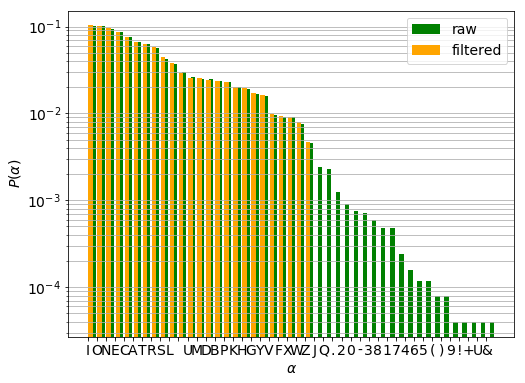

In [82]:
# TO HIDE
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

ax.set_xticks(range(n_letter), raw_chars)
ax.bar(np.arange(0.6, n_letter), r_raw_freqs, width = 0.5, label = 'raw', color = 'green')
ax.bar(np.arange(0.3, len(chars)), p_freqs, width = 0.5, label = 'filtered', color = 'orange')

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$P(\alpha)$')
ax.set_xticks(np.arange(n_letter))
ax.set_xticklabels(raw_chars)
ax.yaxis.grid(which = 'both')
plt.yscale('log')
plt.legend(loc = 'best', ncol = 1 , fancybox=True)

plt.show()

The distribution of characters that appear both in the raw and filtered sets are nearly identical which is confirmed by the $\chi^{2}$-test. It can thus be confirmed removing the words containing infrequent characters has not changed considerably our sample.

In [83]:
f_obs = np.asarray([freqs, raw_freqs[:len(freqs)]])
chi2_, p, dof, f_epx = chi2_contingency(f_obs)

print("P-value: {0}".format(p))

P-value: 0.999999997133692


#### Comparison to natural letter frequencies

It is interesting to compare the character frequency in the coin names to that of the English language. The reference distribution can be found [here](http://pi.math.cornell.edu/~mec/2003-2004/cryptography/subs/frequencies.html). They are loaded into a dictionary with letters as keys and the normalised frequencies as values.

In [84]:
with open('char_freq.json', 'r') as fproc:
    ref_letter_frequency = json.load(fproc)
    
ref_letter_frequency = {x.upper() : float(y) / 100.0 for x, y in ref_letter_frequency.items()}

The letter frequency of the names can easily be calculated, however, one has to make sure that only those letters are taken into account that appear in the reference list.

In [85]:
letter_frequency =  dict(filter(lambda x: x[0] in ref_letter_frequency, char_frequency.items()))  

sum_ = sum(letter_frequency.values())
letter_frequency = {x : float(y) / sum_ for x, y in letter_frequency.items()}    # normalise

missing_letters = set(ref_letter_frequency.keys() - letter_frequency.keys())     # letters not in names
letter_frequency.update({x : 0 for x in missing_letters})

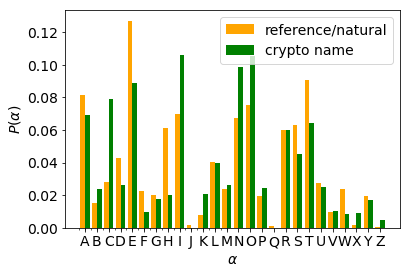

In [86]:
# == TO HIDE

n_letter = len(ref_letter_frequency)

kkk = [y for x, y in sorted(letter_frequency.items())]
lll = [y for x, y in sorted(ref_letter_frequency.items())]

fig, ax = plt.subplots(1,1)
#fig.set_size_inches(12,10)
ax.set_xticks(range(n_letter), letter_frequency.keys())
ax.bar(np.arange(0.3, n_letter) * 2, lll, width = 0.8, label = 'reference/natural', color = 'orange')
ax.bar(np.arange(0.7, n_letter) * 2, kkk, width = 0.8, label = 'crypto name', color = 'green')

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$P(\alpha)$')
ax.set_xticks(np.arange(0.5, n_letter) * 2)
ax.set_xticklabels(ref_letter_frequency.keys())

plt.legend(loc='best', ncol = 1, fancybox = True)
plt.show()

It is readily seen that the two distributions markedly differ. 

### Name length



If we assume there is a fixed average name length and the name lenghts are distributed independently, we can try to model the length distribution with Poisson distribution. The exponent, the only parameter of the distribution is approximated by the mean of the observed word lengths.

In [87]:
name_len_histo = np.bincount(name_df['name_len'].values) * 1.0
name_len_histo /= max(1.0, np.sum(name_len_histo)) # dirty, I know -- but we also know that the legths are 0< integers

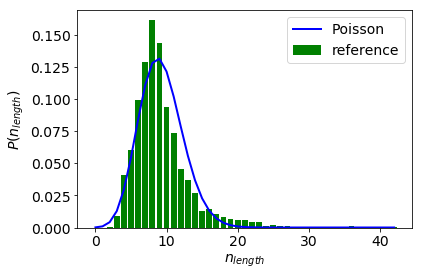

In [88]:
# TO HIDE

mu = name_df['name_len'].mean()
n_max_len = name_df['name_len'].max() + 1
x = np.arange(0, n_max_len)

fig, ax = plt.subplots(1,1)
#fig.set_size_inches(8, 6)
ax.plot(x, poisson.pmf(x, mu), color = 'blue', linewidth = 2, label = 'Poisson')
ax.bar(x, name_len_histo, color = 'green', label = 'reference')

ax.set_xlabel(r'$n_{length}$')
ax.set_ylabel(r'$P(n_{length})$')

plt.legend(loc='best', ncol = 1, fancybox = True)
plt.show()

We can then perform a [ $\chi^{2}$-test](http://www-stat.wharton.upenn.edu/~lbrown/Papers/) on the [Anscombe transdormed](https://en.wikipedia.org/wiki/Anscombe_transform) data from which it can be established that the length distribution is not Poisson.

In [89]:
name_df['trf_vals'] = name_df['name_len'].apply(lambda x: np.sqrt(x + 0.375))
trf_vals = name_df['trf_vals'] - name_df['trf_vals'].sum()

chisq = np.dot(trf_vals,trf_vals)  
print(chi2.sf(chisq, name_df.shape[0]))

0.0


## Generating crytocurrency names

Our aim is to generate cryptocurrency names. The is a manifold of possible algorithms to achieve this. We are going to use a simple Markov model. We, therefore, have to know what what the probability of various character sequences across all coin names. The two letter sequences are counted below:

In [90]:
make_doublets = lambda x: zip(x[:-1], x[1:])
make_doublet_histo = lambda x: Counter(chain(*map(lambda x: make_doublets(x), x)))

In [91]:
pair_histo = make_doublet_histo(name_df['name'].values)

The overwhelming abundance of the word _coin_ is readily recognised from the list of five most common sequences:

In [92]:
for pair, cnt in pair_histo.most_common(15):
    print("{0}\t:\t{1}".format(pair, cnt))
 

('I', 'N')	:	1246
('C', 'O')	:	1067
('O', 'I')	:	991
('E', 'N')	:	309
('E', 'R')	:	293
('I', 'T')	:	278
('T', 'O')	:	250
('R', 'E')	:	236
('A', 'R')	:	231
(' ', 'C')	:	215
('O', 'N')	:	197
('B', 'I')	:	190
('K', 'E')	:	187
('N', 'E')	:	184
('T', 'E')	:	167


The function [`counter_to_np_histo`](### Functions to create and manipulate `numpy` histograms) creates a 2D histogram of the character pairs. The rows correspond to the first character, whereas he columns hold the second character of every doublet.  The additional keyword `with_recorder` returns the index $\rightarrow$ key element mapping. 

The doublet histogram is then calculated:

In [93]:
histo, decoder = counter_to_np_array(pair_histo, with_decoder = True)
xlabels = ylabels = decoder.values()

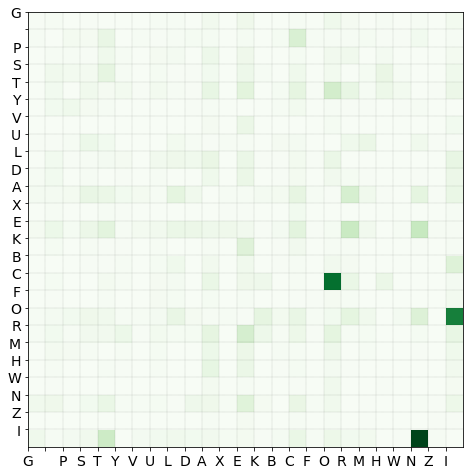

In [94]:
# TO HIDE
plot_histomat(histo, xlabels = xlabels, ylabels = ylabels)
plt.show()

It is quickly checked whether any characters (a column and a row of the same index) can be removed. This would be the case if there are name that consist of a single character, and that character does not appear in any other names. 

Other limiting cases:

* if a character is always terminal in all names it appears, its row is empty
* if a character is always the first one in all names it apprears, its column will be empty

We can confirm that all characters are connected to at least one other character:

In [95]:
is_terminal = np.any(histo.sum(axis = 1) == 0.0)
is_starting = np.any(histo.sum(axis = 0) == 0.0)
is_standalone = is_terminal & is_starting

chooser = lambda x: 'yes' if x else 'No-o'

print("-Are there standalone characters? \n-The computer says {0}.".format(chooser(is_standalone)))
print("-Are there start only characters? \n-The computer says {0}.".format(chooser(is_starting)))
print("-Are there terminal only characters? \n-The computer says {0}.".format(chooser(is_terminal)))

-Are there standalone characters? 
-The computer says No-o.
-Are there start only characters? 
-The computer says No-o.
-Are there terminal only characters? 
-The computer says No-o.


### Transition probability matrix

The row normalised histogram is the transition matrix $P$, `tmat`,  where $P_{ij}$ is the probability that character $i$ is followed by character $j$.

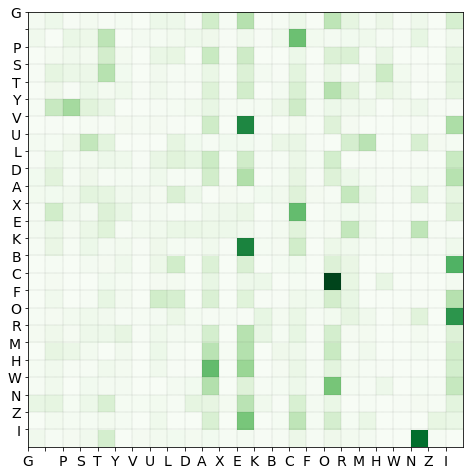

In [96]:
tmat = normalize(histo, norm = 'l1', axis = 1)
plot_histomat(tmat, xlabels = xlabels, ylabels = ylabels)
plt.show()

### Markov model

Under the assumption that a character is only determined by the preceeding character, one can build a Markov model of the names. (We will see it is not a valid assumption later on.) The class `MarkovSequenceGenerator` creates a generator of Markov chain.

In [97]:
class MarkovSequenceGenerator(object):
    """
    Class to generate Markov sequences.
    
    Attributes:
        decoder ({int:object}) : dictionary that decodes the states
        encoder ({object:int}) : dictionary that assigns a unique index to every state
        transition_matrix (np.ndarray) : row normalised transition probability matrix
        
    Methods:
        create_sequence_generator (generator.object) : a generator which yields Markov sequences. 
        Each returned item is a generator of a Markov sequence.
    """
    
    def __init__(self, transition_matrix, decoder, random_state = None):
        """
        transition_matrix (np.ndarray) : row normalised transition probability matrix
        decoder ({int:object}) : dictionary that decodes the states
        """
        
        self._decoder = decoder
        self._encoder = dict(zip(decoder.values(), decoder.keys()))
        self._transition_matrix = transition_matrix
        
        # calculate cumulative probabilities for sampling
        self.__cumprob_matrix = np.cumsum(self.transition_matrix, axis = 1)

    @property
    def decoder(self):
        return self._decoder
    
    @property
    def encoder(self):
        return self._encoder
            
    @property
    def transition_matrix(self):
        return self._transition_matrix
    
    def create_sequence_generator(self, start):
        """
        Creates a generator of a Markov sequence.
        Parameters:
            start (object) : starting state
        Returns:
            sequence_generator (generator) : a generator object of a Markov sequence
        """
        
        if start not in self.encoder.keys():
            raise KeyError("Start value not in known states. Got: {0}".format(start))
 
        self.__idx = self._encoder[start]

        def sequence_generator(start_index):
            """
            A Markov sequence. 
                Returns the state at `start_index`
                Propagates the chain by one step.
            Parameters:
                start_index (int) : index of the starting Markov state. 
            """
            
            idx = start_index

            while True:
                
                if idx is None:
                    return
                
                symbol = self._decoder[idx]
                idx = self._propagate_one_step(idx)  
                
                yield symbol
                
        return sequence_generator(self.__idx)
    
    def _propagate_one_step(self, idx):
        """
        Propagates the Markov chain by one step.
        Parameters:
            idx (int) : index of the current Markov state.
        Returns:
            next_idx (int) or None: the index of the next Markov state. None if the chain ended.
        """
        
        x = np.random.rand()
        
        # nowhere to go
        if self.__cumprob_matrix[idx, -1] == 0.0:
            return
        else:
            next_idx = int(np.argwhere(self.__cumprob_matrix[idx] - x > 0.0)[0])

        return next_idx

Three random sequences are then generated.

In [98]:
msqg = MarkovSequenceGenerator(tmat, decoder)

n_seq_len = 50
seqs = (msqg.create_sequence_generator(start) for start in ['C', 'C', 'Y'])

for seq in seqs:
    print("".join(islice(seq, n_seq_len)))

COT INUKRDCENLE HARININDENERRBIBLLICTOIASHLOINENEL
COINCTINE NERTOIOAMENSTAINDOYPERCOINANDSTBENTARISP
YCKE EZEMALYPECUCRYWER BININOICOINN NECOINDERSTHEX


The 'C|O|I|N' motiff can be recognised in all strings. These strings are infinite for there are no terminal only characters. In order to make them finite we have to modify our model. 

#### Start and terminating symbols

These continuous sequences reflect the probability of 2-long sequences in _all_ of the original names. Our model bears little information on the distribution of starting and ending characters. Therefore the names are blended into each other.

This can be recitfied by bracketing each orginal name with start and terminating symbols. Each of them will be prepended with the start symbol **'^'**  appended by the terminating symbol **'$'**. 

In [99]:
start_symbol = '^'
end_symbol = '$'
name_df['aug_name'] = name_df['name'].apply(lambda x: start_symbol + x + end_symbol)

We can then calculate the transition matrix, now containing the delimting characters, in the way we did previously:

In [100]:
# create histogram with decoder
pair_histo_aug = make_doublet_histo(name_df['aug_name'].values)
histo_aug, decoder_aug = counter_to_np_array(pair_histo_aug, with_decoder = True)

# transition matrix and labels
tmat_aug = normalize(histo_aug, norm = 'l1', axis = 1)
xlabels = ylabels = decoder_aug.values()

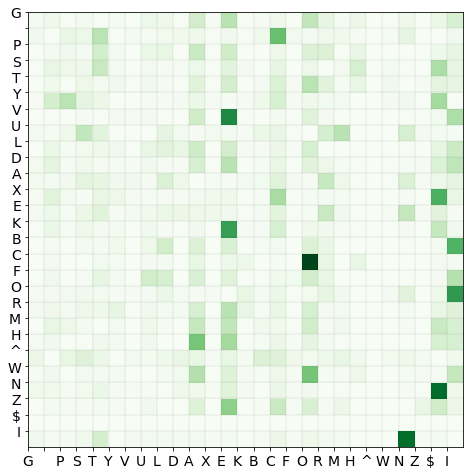

In [101]:
# TO HIDE
plot_histomat(tmat_aug, xlabels = xlabels, ylabels = ylabels)
plt.show()

We then generate an infinite succession of Markov sequences which are themselves finite called `seqs`.

In [102]:
msqg_aug = MarkovSequenceGenerator(tmat_aug, decoder_aug)
seqs =  (msqg_aug.create_sequence_generator(x) for x in repeat(start_symbol))

Ten sequences are then consumed. Each of them corresponds to a generated cryptocurrency name.

In [103]:
n_seqs = 10
for idx, seq in enumerate(islice(seqs, n_seqs)):
    print(idx, "\t:\t", "".join(seq))

0 	:	 ^RINLBIN$
1 	:	 ^COITS$
2 	:	 ^KECOSY$
3 	:	 ^MITCOIAYM$
4 	:	 ^COIOTIN$
5 	:	 ^GRESANCENARSCO AL BUMBINGHOK$
6 	:	 ^LOCHEN$
7 	:	 ^VEN$
8 	:	 ^TOIUARTROLERARICHGON$
9 	:	 ^LEUN$


### How good is our model?

First of all one has to define what goodness means. There is a plethora of properties that can be calculated for both the reference and generated sets. Some of them are expected to be identical, such as character and digram frequencies. Some of them _e.g._ name length distribution are not, for the Markov process has no information about its length.

Firstly, we test the digram frequencies. The measure of goodness will be the L2 distance between the digram distributions. The overlap will depend on the sample size. Thus we use a succession of samples of increasing size to test this effect.

The population of generated words is called `generated_words`.

In [104]:
generated_words = np.asarray(["".join(seq) for seq in islice(seqs, 20000)])

In [105]:
sample_specs = {100 : 10, 500 : 10, 1000 : 10, 2000 : 10, 5000 : 10, 10000 : 10}
encoder_aug = dict(zip(decoder_aug.values(), decoder_aug.keys()))

sample_size_log, diff_log = [], []

for sample_size, repeats in sample_specs.items():
    
    for idx in range(repeats):
        # sample names and create transition matrix
        sample = np.random.choice(generated_words, size = sample_size)
        sample_histo = fill_np_array_with_counter(make_doublet_histo(sample), encoder_aug)
        
        # calculate difference
        diff = normalised_l2_diff(sample_histo, histo_aug)
        diff_log.append(diff) 
        sample_size_log.append(sample_size)

The digram frequencies of the reference and generated names converge to each other as the sample size increases. At a sample size of 2000 the two distributions are practically identical

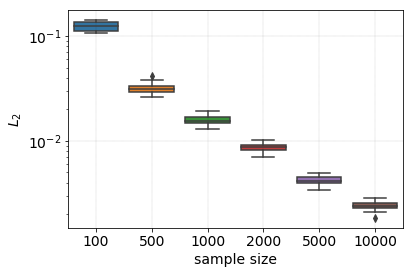

In [106]:
# TO HDE       
fig, ax = plt.subplots(1,1)
ax.set_xlabel("sample size")
ax.set_ylabel(r'$L_{2}$')
ax.set_yscale("log")

sns.boxplot(x = np.asarray(sample_size_log), y = np.asarray(diff_log), ax = ax)
ax.xaxis.grid(color  = 'black', linestyle='--', linewidth = 0.1)
ax.yaxis.grid(color  = 'black', linestyle='--', linewidth = 0.1)

plt.show()

#### Name length distribution

Next, the length distributions of the reference and generated names are compared. The percentile bootstrap method is invoked to estimate the distributions and their confidence bands. A simple bootstrap algorithm is implemented in the [`SlimBootstrap` class](### Bootstrap class).

Firstly, the lengths of the generated names are calculated.

In [107]:
word_lengths = np.array([len(x) for x in generated_words])
max_len = np.max(word_lengths)

The bootstrap estimate and confidence bands are stored in the `wl_dist` array.

In [108]:
bins = np.arange(max_len + 1)
bstr = SlimBootstrap(func = sample_to_distribution, func_kwargs = {'bins' : bins})
wl_dist = bstr.fit_predict(word_lengths)

We then bootstrap the reference cryptocurrency names and compare the two distributions.

In [109]:
ref_word_lengths = name_df['name_len'].values
ref_bstr = SlimBootstrap(func = sample_to_distribution, func_kwargs = {'bins' : bins})
ref_wl_dist = bstr.fit_predict(ref_word_lengths)

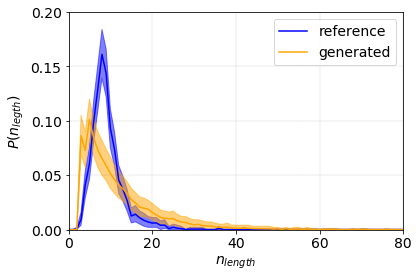

In [110]:
# TO HIDE
fig, ax = plt.subplots(1,1)

ax.plot(np.arange(ref_wl_dist.shape[1]), ref_wl_dist[0], color = 'blue', label = 'reference')
ax.fill_between(np.arange(ref_wl_dist.shape[1]), ref_wl_dist[1], ref_wl_dist[2], 
                color = 'blue', alpha = 0.5)

ax.plot(np.arange(wl_dist.shape[1]), wl_dist[0], color = 'orange', label = 'generated')
ax.fill_between(np.arange(wl_dist.shape[1]), wl_dist[1], wl_dist[2], 
                color = 'orange', alpha = 0.5)

ax.grid(color  = 'black', linestyle='--', linewidth = 0.1)
ax.set_xlim((0, 80))
ax.set_ylim((0, 0.2))

ax.set_xlabel(r'$n_{length}$')
ax.set_ylabel(r'$P(n_{legth})$')
plt.legend(loc='best', ncol = 1, fancybox = True)

plt.show()

The two distributions markedly differ. The generated distribution is much wider and peaks at shorter lengths with respect to the reference one. This is due to the fact that the Markov model does not have memory. The probability that a sequence (a name) ends only depends on the probability of current character followed by the end symbol. It is independent of the absulute position of the current charachter.

This defect of the model can be mitigated by the inclusion of 3-grams, 4-gramms etc in the Markov matrix. Also, one can design a recurrent neural network where the information on all to preceeding characters are used with some weight.

### Remarks

The goodness of fit warrants some further attention. Let us assume we have an alphabet $\Sigma$ whose Kleene star, $L$, contains every possible (existing or yet to be coined) crytocurrency names, $L_{c,all}$. The current selection of crytocurrency names, $L_{c}$, is a subset of all cryptocurrency names.

$$
\begin{eqnarray}
L &=& \Sigma^{*} \\
L_{c,all} &\subseteq & L \\
L_{c} & \subseteq & L_{c,all}
\end{eqnarray}
$$

Our model can only use the alphabet $\Sigma$ and is required to produce words that are in $L$. The all possible generated names constitute the set $L_{g, all}$ which has a subset the realised names, $L_{g}$. One can think of the $L_{g, all}$ as all the Markov sequences, and $L_{g}$ as those are consumed.

$$
\begin{eqnarray}
L_{g,all} & \subseteq & L \\
L_{g} &\subseteq& L_{g,all}
\end{eqnarray}
$$

Our aim is to write a model which maximises the $L_{g} \cap L_{c,all}$ intersection. It is immediately seen this task is ill-defined for the following issues:

* We do not know how the sizes of $L_{g}$ and $L_{g, all}$ compare. We therefore have to experiment at which sample size the fluctuations of its statistical properties of interest subdue to a sufficient level.
* We also do not know whether the properties of $L_{c}$ are true representatives those of $L_{c, all}$. We can only assume they are identical.
* The fluctuations of the properties of $L_{c}$ should also be estimated in order to determine to what extent to randomly selected not overlapping subset of $L_{c}$ are identical with respect to these properties. (i.e. if we train on a model on a subset, how well it is expected to perform.)
* As a consequence the goodness of the model can only be estimated by comparing the selected properties of $L_{g}$ and $L_{c}$.

In fact, this is exactly what we did when bootstrapped the reference and generated length distributions.

## Appendix

These functions were used in the main body of the post. They deliver only a modest amount of excitement hence I moved them to the Appendix.

### Functions to create and manipulate `numpy` histograms

In [111]:
def counter_to_np_array(counter, with_decoder = False):
    """
    Creates a numpy array based on a counter.
    Parameters:
        counter (collection.Counter) : a counter of length 2 keys
        with_decoder (bool) : if True returns a decoder dictionary. Default: False.
    Returns:
        array (np.ndarray) : 2D numpy array where each index corresponds to a key in counter. 
        The value at a certain index is the corresponding count
        decoder ({:}) : a index : key dictionary if `with_decoder` is True
    """
    
    # key must be an iterable of length two
    key, count = counter.most_common(1)[0]
    key = list(key)
    
    if len(key) != 2:
        raise KeyError("counter key must be of length 2. Got: {0}".format(len(key)))
        
    # decompose to key count pairs
    keys, counts = counter.keys(), counter.values()
    
    # encode keys
    unique_symbols = set(chain(*keys))
    encoder = dict(zip(unique_symbols, range(len(unique_symbols))))
    xy = np.asarray([encoder[x] for x in chain(*keys)])
    xy = np.reshape(xy, (xy.shape[0] // 2, 2))

    # create histogram
    bins = np.arange(np.max(xy) + 2)
    weights = np.array(list(counts))
    array, _, _ = np.histogram2d(xy[:,0], xy[:,1], bins = [bins, bins], weights = weights)
    
    # add decoder if requested
    if with_decoder:
        decoder = dict(zip(encoder.values(), encoder.keys()))
        
        return array, decoder
    else:
        return array

In [112]:
def fill_np_array_with_counter(counter, encoder):
    """
    Fills a numpy array with a counter. It performs a *key --> *index transformation.
    Parameters:
        counter (collections.Counter) : a counter where all keys are of equal length.
        encoder ({}) : the keys are the keys of the counter (or a superset thereof) the values are integer indices.
    Returns:
        array (np.ndarray) : numpy array with counts.
    """
    
    n_size = len(encoder)
    mat = np.zeros(shape = (n_size, n_size), dtype = np.float)
    
    for (kx, ky), count in counter.items():
        mat[encoder[kx], encoder[ky]] = count
        
    return mat

### Miscellaneous numeric functions

In [113]:
def normalised_l2_diff(p, q):
    """
    Calculates the normalised L2 difference between two arrays.
    Parameters:
        p (np.ndarray) : first distribution
        q (np.ndarray) : second distribution
    Returns:
        diff (np.float) : the L2 difference between the normalised p, and q distributions
    """
    
    p_ = normalize(p)
    q_ = normalize(q)
    
    denominator = (np.square(p_) + np.square(q_))
    if not np.any(denominator):
        raise ValueError("Both distributions are zero.")
        
    diff = np.sum(np.square(p_ - q_)) / np.sum(denominator)
    
    return diff

In [114]:
def sample_to_distribution(arr, *args, **kwargs):
    hist =  np.histogram(arr, *args, **kwargs)[0]
     
    sum_ = np.sum(hist)
    if sum_ == 0.0:
        hist = np.zeros(hist.shape)
    else:
        hist = hist * 1.0 / sum_ 
    
    return hist

### Miscellaneous helper functions

In [115]:
def load_df_from_json(path_to_file, orient = 'index'):
    """
    Loads a pandas dataframe from a json file.
    Parameters:
        path_to_file (str) : **full** path to the json storage
        orient (str) : orientation of the json (see pandas.read_json for details)
    Returns:
        df (pandas.DataFrame) : a dataframe
    """
    with open(path_to_file, 'r') as fproc:
        df = pd.read_json(fproc, orient = orient)        
    return df

### Plotting functions

In [116]:
def plot_histomat(mat, ax = None, xlabels = None, ylabels = None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(8,8)
        
    n_xticks, n_yticks = mat.shape
    
    extent = (0, n_xticks, n_yticks, 0)
    
    ax.grid(color  = 'black', linestyle='--', linewidth = 0.1)
    
    ax.set_xticks(np.arange(n_xticks))
    ax.set_yticks(np.arange(n_yticks))
    
    if xlabels is not None:
        ax.set_xticklabels(xlabels)
    
    if ylabels is not None:
        ax.set_yticklabels(ylabels)
    
    ax.imshow(mat, extent = extent, cmap = 'Greens', vmin = 0)

### Bootstrap class

In [117]:
class SlimBootstrap(object):
    """
    Simple percentile bootstrap class.
    Attributes:
        n_resample (int) : number of samples
        sample_size (int) : sample size -- number of elements taken from the population.
        alpha (float) : significance level at which the confidence interval is calculated
    
    Methods:
        fit() : calculates the percenticle bootstrap estimate and confidence bands
        fit_predict() : returns the calculated estimate and confidence bands
    """
    
    def __init__(self, n_resample = 2000, sample_size = 1000, alpha = 0.05,
                 func = lambda x: x, func_args = [], func_kwargs = {}):
        """
        Parameters:
            n_resample (int) : number of samples. Default 2000.
            sample_size (int) : sample size -- number of elements taken from the population. Default 1000.
            alpha (float) : significance level at which the confidence interval is calculated. Default 0.05.
            func (callable) : function which is applied to the samples. The result of this function is bootstrapped.
                The bootstrap function can return any object as long as it can be cast to a regular np.ndarray
                Default : identity function
            func_args ([]) : positional arguments of func. Default [].
            func_kwargs ({:}) : keyword arguments of func. Default {}.
        """
        
        self._n_resample = n_resample
        self._sample_size = sample_size
        self._alpha = alpha
        self._func = func
        self._func_args = func_args
        self._func_kwargs = func_kwargs
    
    @property
    def alpha(self):
        return self._alpha
    
    @property
    def n_resample(self):
        return self._n_resample
    
    @property
    def sample_size(self):
        return self._sample_size
    
    def _generate_samples(self):
        self.__samples = (np.random.choice(self.__population, self.sample_size) 
                              for i in range(self.n_resample))
    
    def _set_population(self, population):
        self.__population = population
            
    def fit(self, population):
        """
        Calculates the bootstrap estimate and confidence bands. 
        Parameters:
            population (indexable) : the population to be sampled.
        Returns:
            self
        Notes:
            The return values of the function are sorted along the first axis.
        """
    
        self._set_population(population)
        
        self._generate_samples()
    
        # 1) It would be better to apply the function to the entire population
        # simultaneously. However, it is not granted that the function is written that way.
        
        # 2) consume the generator here, so it can be cast as an array quicker
        measurements = list(self._func(x, *self._func_args, **self._func_kwargs) 
                                for x in self.__samples)

        store = np.array(measurements)
        
        # sort in place along first axis
        store.sort(axis = -store.ndim)
        
        # bootstrap estimate
        estimate = np.mean(store, axis = -store.ndim)
        
        # confidence bands
        i_low = int(self._alpha / 2.0 * self._n_resample)
        i_up = int((1.0 - self._alpha / 2.0) * self._n_resample)
        
        cb_low = store[i_low]
        cb_up = store[i_up]
        
        self._result = np.array((estimate, cb_low, cb_up))
        
        return self
    
    def fit_predict(self, population):
        """
        Convenience wrapper around the `fit` method.
        Parameters:
            population (indexable) : population to be sampled
        Returns:
            self._result (np.ndarray) : the estimate and confidence bands
            _result[0] : estimate
            _result[1] : lower bound of confidence band
            _result[2] : upper bound of confidence band
        """
        return self.fit(population)._result